In [14]:
import random

import gymnasium as gym
import numpy as np

import tensorflow as tf

from keras import Model
from keras.layers import Dense

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [15]:
class DQN(Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        self.replay_memory = []

        self.dense1 = Dense(48, activation="tanh", input_dim=state_size)
        self.dense2 = Dense(action_size, activation="softmax")

    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)
    
    
    def remember(self, state, action, reward, next_state, done):
        self.replay_memory.append((state, action, reward, next_state, done))

In [16]:
def update_model(model: DQN):
    # 리플레이 버퍼 크기가 작으면 업데이트하지 않음
    if len(model.replay_memory) < 1000:
        return
    
    # 너무 많으면 리플레이 버퍼 pop
    if len(model.replay_memory) > 10000:
        model.replay_memory.pop(0)

    # 메모리에서 랜덤 샘플링
    samples = random.sample(model.replay_memory, 64)

    # 분할
    states, actions, rewards, next_states, dones = zip(*samples)
    # states, actions, rewards, next_states, dones = zip(*model.replay_memory)

    # numpy 배열로 변환
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)

    # 모델 예측
    q_values = model.call(states).numpy()
    next_q_values = model.call(next_states).numpy()

    # 타겟 값 계산
    targets = q_values.copy()
    targets[np.arange(len(rewards)), actions] = rewards + 0.99 * np.max(next_q_values, axis=1) * (1 - dones)

    # 모델 업데이트
    with tf.GradientTape() as tape:
        q_values = model.call(states)
        loss = tf.keras.losses.mean_squared_error(targets, q_values)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [17]:
import matplotlib.pyplot as plt

def draw_qvalue(model, episode):
    positions = np.arange(-1.2, 0.6, 0.02) 
    velocities = np.arange(-4, 4, 0.1)

    states = np.array([[position, velocity] for position in positions for velocity in velocities])
    z = model.call(states).numpy()

    z_np = np.array(z).reshape((len(positions), len(velocities), 3))

    # x, y, z를 2차원 그래프로 표현
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle("Episode: {}".format(episode))
    for i in range(3):
        ax[i].title.set_text("Action: {}".format(i))
        ax[i].imshow(z_np[:,:,i], cmap='hot', interpolation='nearest', clim=(0, 1))
        ax[i].set_xticks(np.arange(0, 80, 10))
        ax[i].set_yticks(np.arange(0, 90, 10))
        ax[i].set_xticklabels(np.arange(-4, 4, 1))
        ax[i].set_yticklabels(np.round(np.arange(-1.2, 0.6, 0.2),1))
        ax[i].set_xlabel("Velocity")
        ax[i].set_ylabel("Position")
        ax[i].invert_yaxis()  # y축 변경
    plt.tight_layout()
    plt.savefig("images/episode_{}.png".format(episode))

Episode: 0, Steps: 1000, Max Score: -0.2555809020996094
Episode: 1, Steps: 1000, Max Score: -0.23800519108772278
Episode: 2, Steps: 1000, Max Score: -0.2986973226070404
Episode: 3, Steps: 1000, Max Score: -0.2698003947734833
Episode: 4, Steps: 1000, Max Score: -0.32316145300865173


KeyboardInterrupt: 

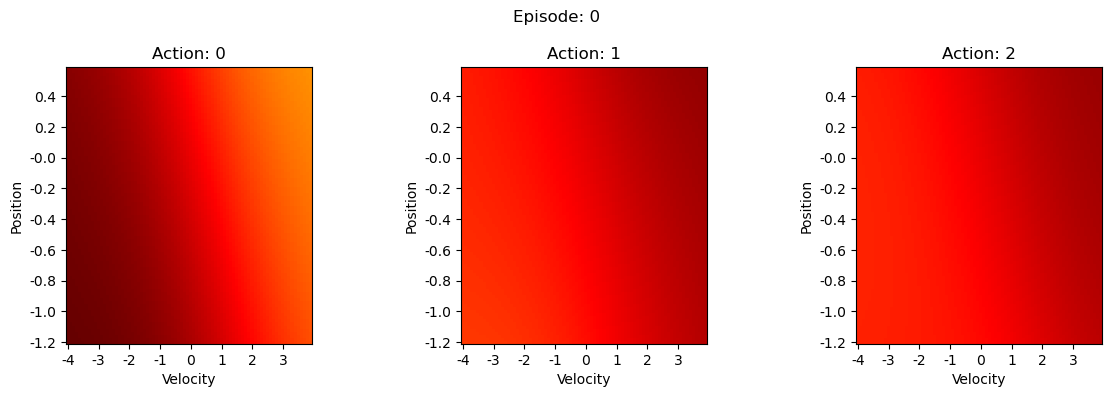

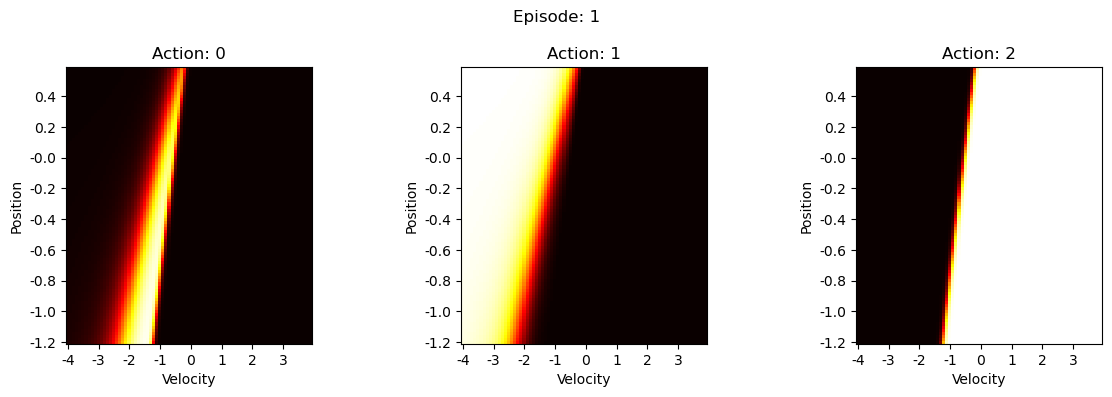

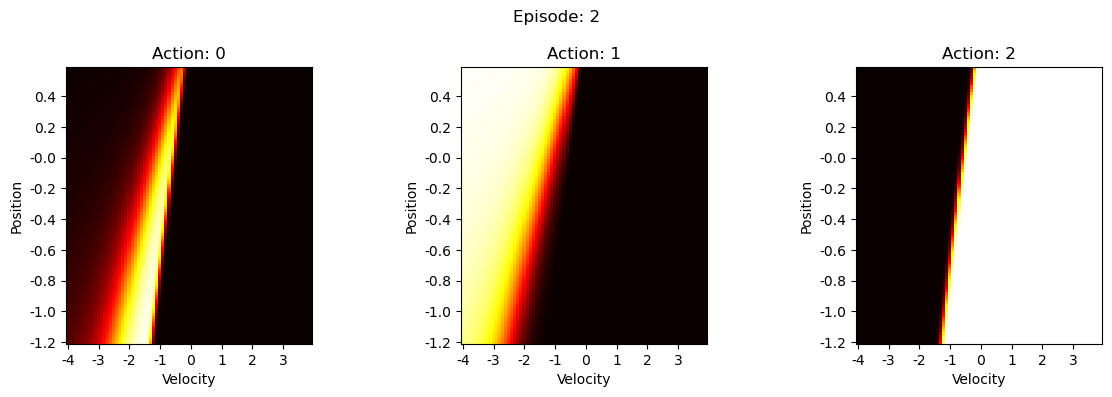

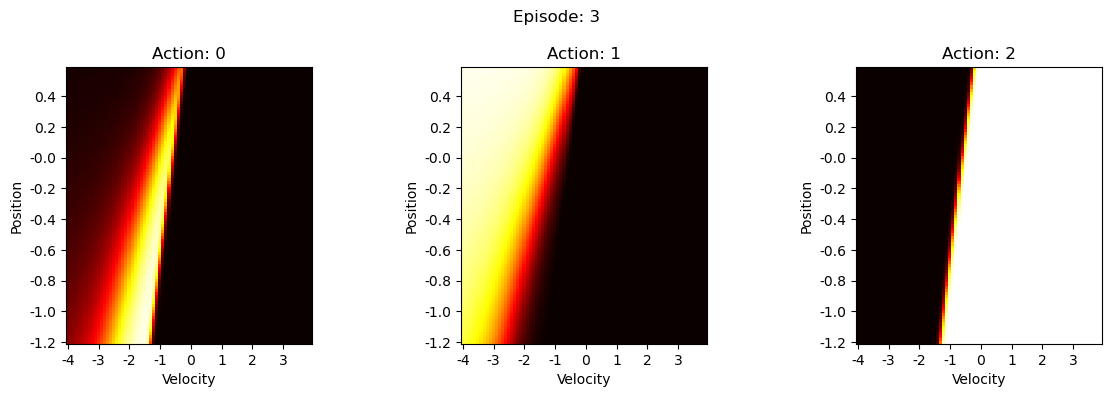

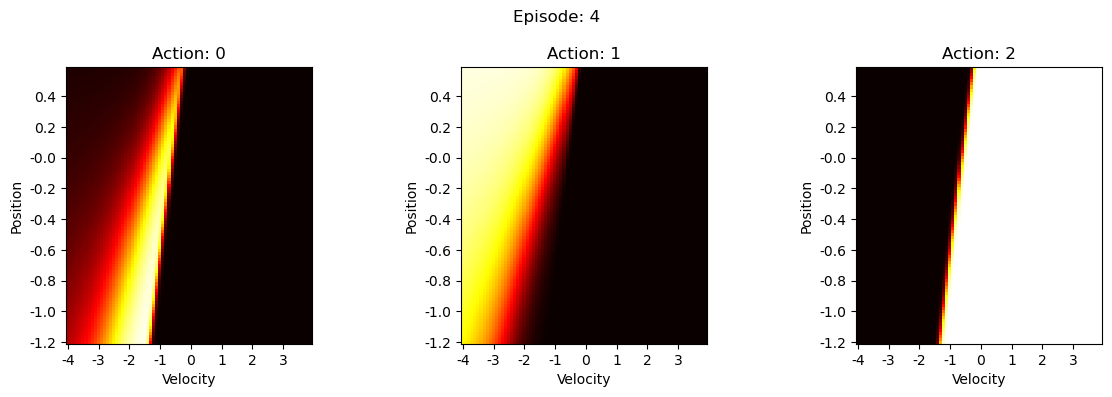

In [18]:
env = gym.make("MountainCar-v0")
# env = gym.make("MountainCar-v0", render_mode="human")
model = DQN(env.observation_space.shape[0], env.action_space.n)

for episode in range(50):
    state, info = env.reset()
    terminated = False
    truncated = False
    step = 0
    
    max_score = state[0]
    
    while not terminated and step < 1000:

        # 모델로 행동 예측
        q_values = model.call(np.array([state])).numpy()[0]
        
        # 소프트맥스 확률로 행동 선택
        action = np.random.choice(env.action_space.n, p=q_values)

        # 행동 실행
        next_state, reward, terminated, truncated, info = env.step(action)
        max_score = max(max_score, next_state[0])

        if episode < 20:
            if next_state[1] > 0 and action == 2:
                reward = 5
            elif next_state[1] < 0 and action == 0:
                reward = 5
            if terminated:
                reward = 100

        if episode >= 20:
            if terminated:
                reward = 100

        # 리플레이 버퍼에 기억
        model.remember(state, action, reward, next_state, terminated)
        
        # 모델 업데이트
        update_model(model)

        state = next_state
        step += 1

    draw_qvalue(model, episode)
    
    print("Episode: {}, Steps: {}, Max Score: {}".format(episode, step, max_score))


env.close()